<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/2019%20Fastai%20Deep%20Learning/2019_Deep_Learning_3_Camvid_ImageSegmentation(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentation example: CamVid [56:31](https://youtu.be/PW2HKkzdkKY?t=3391)

[Notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb)

The next example we're going to look at is this dataset called CamVid. It's going to be doing something called segmentation. We're going to start with a picture like the left:

![alt text](https://github.com/hiromis/notes/blob/master/lesson3/c1.png?raw=true)
![alt text](https://github.com/hiromis/notes/blob/master/lesson3/c2.png?raw=true)

and we're going to try and create a color-coded picture like the right where all of the bicycle pixels are the same color, all of the road line pixels are the same color, all of the tree pixels are the same color, all of the building pixels are the same color, the sky the same color, and so forth.

Now we're not actually going to make them colors, we're actually going to do it where each of those pixels has a unique number. In this case the top left is building, so I guess building is number 4, the top right is tree, so tree is 26, and so forth.

**In other words, this single top left pixel, we're going to do a classification problem just like the pet's classification for the very top left pixel. We're going to say "What is that top left pixel? Is it bicycle, road lines, sidewalk, building?". Then, "What is the next pixel along?". So we're going to do a little classification problem for every single pixel in every single image. That's called segmentation.**

In order to build a segmentation model, you actually need to download or create a dataset where someone has actually labeled every pixel. As you can imagine, that's a lot of work, so you're probably not going to create your own segmentation datasets but you're probably going to download or find them from somewhere else.

**This is very common in medicine and life sciences. If you're looking through slides at nuclei, it's very likely you already have a whole bunch of segmented cells and segmented nuclei. If you're in radiology, you probably already have lots of examples of segmented lesions and so forth. So there's a lot of different domain areas where there are domain-specific tools for creating these segmented images. As you could guess from this example, it's also very common in self-driving cars and stuff like that where you need to see what objects are around and where are they.**

In this case, there's a nice dataset called CamVid which we can download and they have already got a whole bunch of images and segment masks prepared for us. Remember, pretty much all of the datasets that we have provided inbuilt URLs for, you can see their details at [https://course.fast.ai/datasets](https://course.fast.ai/datasets) and nearly all of them are academic datasets where some very kind people have gone to all of this trouble for us so that we can use this dataset and made it available for us to use. So if you do use one of these datasets for any kind of project, it would be very very nice if you were to go and find the citation and say "Thanks to these people for this dataset". Because they've provided it and all they're asking in return is for us to give them that credit. So here is the CamVid dataset and the citation (on our data sets page, that will link to the academic paper where it came from).

![](https://github.com/hiromis/notes/raw/master/lesson3/30.png?raw=true)

**Question**: Is there a way to use learn.lr_find() and have it return a suggested number directly rather than having to plot it as a graph and then pick a learning rate by visually inspecting that graph? (And there are a few other questions around more guidance on reading the learning rate finder graph) [1:00:26]

- The short answer is no and the reason the answer is no is because this is still a bit more artisanal than I would like. As you can see, I've been saying how I read this learning rate graph depends a bit on what stage I'm at and what the shape of it is. I guess when you're just training the head (so before you unfreeze), it pretty much always looks like this:

![](https://github.com/hiromis/notes/raw/master/lesson3/n1.png?raw=true)

And you could certainly create something that creates a smooth version of this, finds the sharpest negative slope and picked that. You would probably be fine nearly all the time.

But then for you know these kinds of ones, it requires a certain amount of experimentation:

![](https://github.com/hiromis/notes/raw/master/lesson3/n2.png?raw=true)

But the good news is you can experiment. Obviously if the lines going up, you don't want it. Almost certainly at the very bottom point, you don't want it right there because you needed to be going downwards. But if you kind of start with somewhere around 10x smaller than that, and then also you could try another 10x smaller than that. Try a few numbers and find out which ones work best.

And within a small number of weeks, you will find that you're picking the best learning rate most of the time. So at this stage, it still requires a bit of playing around to get a sense of the different kinds of shapes that you see and how to respond to them. Maybe by the time this video comes out, someone will have a pretty reliable auto learning rate finder. We're not there yet. It's probably not a massively difficult job to do. It would be an interesting project﹣collect a whole bunch of different datasets, maybe grab all the datasets from our datasets page, try and come up with some simple heuristic, compare it to all the different lessons I've shown. It would be a really fun project to do. But at the moment, we don't have that. I'm sure it's possible but we haven't got them.

#Image Segmentation [1:03:05](https://youtu.be/PW2HKkzdkKY?t=3785)

So how do we do image segmentation? The same way we do everything else. Basically we're going to start with some path which has got some information in it of some sort.



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

So I always start by un-tarring my data, do an ls, see what I was given. In this case there's a label folder called labels and a folder called **images**, so I'll create paths for each of those.

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

We'll take a look inside each of those

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_009540.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07470.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01290.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01740_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08031_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_007050_P.png')]

**You can see there's some kind of coded file names for the images and some kind of coded file names for the segment masks. Then you kind of have to figure out how to map from one to the other. Normally, these kind of datasets will come with a README you can look at or you can look at their website.**

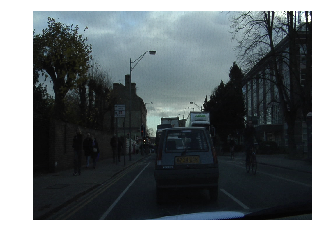

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Often it's obvious. In this case I just guessed. I thought it's probably the same thing + _P, so I created a little function that basically took the filename and added the _P and put it in the different place (path_lbl) and I tried opening it and I noticed it worked.

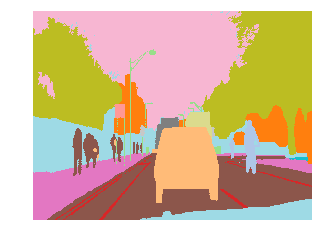

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

So I've created this little function that converts from the image file names to the equivalent label file names. I opened up that to make sure it works. Normally, we use **open_image** to open a file and then you can go **.show** to take a look at it, but as we described, this is not a usual image file that contains integers. So you have to use **open_masks** rather than **open_image** because we want to return integers not floats. fastai knows how to deal with masks, so if you go mask.show, it will automatically color code it for you in some appropriate way. That's why we said **open_masks**.

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

We can kind of have a look inside, look at the data, see what the size is. So there's 720 by 960. We can take a look at the data inside, and so forth. 

The other thing you might have noticed is that they gave us a file called **codes.txt** and a file called **valid.txt**.

In [11]:
codes = np.loadtxt(path/'codes.txt',dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

**code.txt** contains a list telling us that, for example, **number 4 is building**. Just like we had grizzlies, black bears, and teddies, here we've got the coding for what each one of these pixels means.

#Creating a data bunch [1:05:53](https://youtu.be/PW2HKkzdkKY?t=3953)

To create a data bunch, we can go through the data block API and say:

- We've got a list of image files that are in a folder.
- We then need to split into training and validation. **In this case I don't do it randomly because the pictures they've given us are frames from videos. If I did them randomly I would be having two frames next to each other: one in the validation set, one in the training set. That would be far too easy and treating**. So the people that created this dataset actually gave us a list of file names (valid.txt) that are meant to be in your validation set and they are non-contiguous parts of the video. So here's how you can split your validation and training using a file name file.
- We need to create labels which we can use that get_y_fn (get Y file name function) we just created .

In [12]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of the bs depends on the available GPU RAM

if free> 8200: bs=8
else:          bs=4
print(f'using bs={bs},have {free}MB of GPU RAM free')

using bs=8,have 15068MB of GPU RAM free


In [0]:
scr = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn,classes=codes))

From that, I can create my datasets.

So I actually have a list of class names. Often with stuff like the planet dataset or the pets dataset, we actually have a string saying this is a pug, this is a ragdoll, or this is a birman, or this is cloudy or whatever. In this case, you don't have every single pixel labeled with an entire string (that would be incredibly inefficient). **They're each labeled with just a number and then there's a separate file telling you what those numbers mean**. So here's where we get to tell the data block API this is the list of what the numbers mean. So these are the kind of parameters that the data block API gives you.

In [0]:
data = (scr.transform(get_transforms(),size=size,tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

Here's our transformations. Here's an interesting point. Remember I told you that, for example, sometimes we randomly flip an image? What if we randomly flip the independent variable image but we don't also randomly flip the target mask? Now I'm not matching anymore. So we need to tell fastai that I want to transform the Y (X is our independent variable, Y is our dependent)﹣I want to transform the Y as well. So whatever you do to the X, I also want you to do to the Y (tfm_y=True). There's all these little parameters that we can play with.

I can create our data bunch. I'm using a smaller batch size (bs=8) because, as you can imagine, I'm creating a classifier for every pixel, that's going to take a lot more GPU right. I found a batch size of 8 is all I could handle. Then normalize in the usual way.

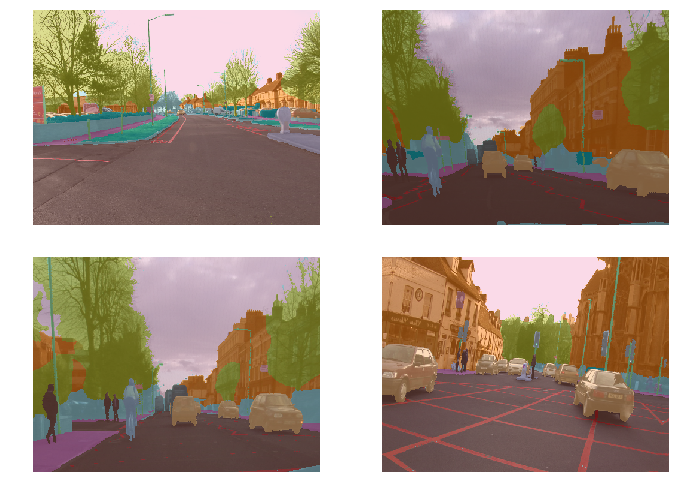

In [15]:
data.show_batch(2,figsize=(10,7))

This is quite nice. Because fastai knows that you've given it a segmentation problem, when you call show batch, it actually combines the two pieces for you and it will color code the photo. Isn't that nice? So this is what the ground truth data looks.



#Training [1:09:00](https://youtu.be/PW2HKkzdkKY?t=4140)
Once we've got that, we can go ahead and

- Create a learner. I'll show you some more details in a moment.
- Call lr_find, find the sharpest bit which looks about 1e-2.
- Call fit passing in slice(lr) and see the accuracy.
- Save the model.
- Unfreeze and train a little bit more.

That's basic idea.


In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [19]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 79183000.36it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


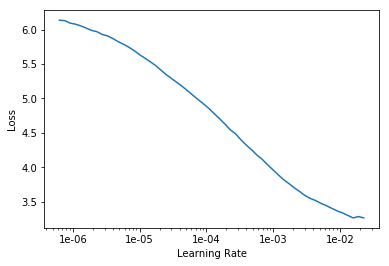

In [20]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [22]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.336932,0.851996,0.763034,01:33
1,0.877029,0.618249,0.842294,01:31
2,0.718627,0.713659,0.824069,01:31
3,0.667102,0.538433,0.858428,01:32
4,0.640941,0.638103,0.831594,01:31
5,0.626983,0.581486,0.851141,01:31
6,0.618187,0.520320,0.855024,01:31
7,0.563313,0.442225,0.878285,01:30
8,0.528309,0.426727,0.880809,01:31
9,0.460218,0.335984,0.900884,01:30


In [0]:
learn.save('stage-1')

In [24]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

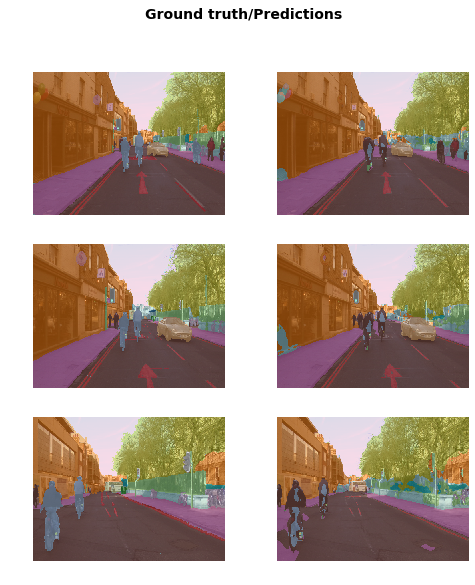

In [25]:
learn.show_results(rows=3,figsize=(8,9))

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


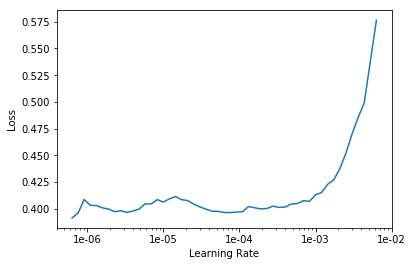

In [27]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lrs=slice(lr/400,lr/4)

In [29]:
learn.fit_one_cycle(12,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.391598,0.325708,0.904920,01:34
1,0.384436,0.330019,0.901481,01:34
2,0.373013,0.318753,0.911229,01:34
3,0.359672,0.327003,0.903468,01:34
4,0.349780,0.318399,0.907270,01:34
5,0.340934,0.273734,0.926140,01:34
6,0.330314,0.282179,0.923275,01:34
7,0.324091,0.290040,0.917287,01:35
8,0.311019,0.326470,0.912321,01:34
9,0.312644,0.276349,0.920841,01:34


In [0]:
learn.save('stage-2')

**Question**: Could you use unsupervised learning here (pixel classification with the bike example) to avoid needing a human to label a heap of images[1:10:03]

- Not exactly unsupervised learning, but you can certainly get a sense of where things are without needing these kind of labels. Time permitting, we'll try and see some examples of how to do that. You're certainly not going to get as such a quality and such a specific output as what you see here though. If you want to get this level of segmentation mask, you need a pretty good segmentation mask ground truth to work with.

**Question**: Is there a reason we shouldn’t deliberately make a lot of smaller datasets to step up from in tuning? let’s say 64x64, 128x128, 256x256, etc… [1:10:51]

- Yes, you should totally do that. It works great. This idea, it's something that I first came up with in the course a couple of years ago and I thought it seemed obvious and just presented it as a good idea, then I later discovered that nobody had really published this before. And then we started experimenting with it. And it was basically the main tricks that we use to win the DAWNBench ImageNet training competition.

- Not only was this not standard, but nobody had heard of it before. There's been now a few papers that use this trick for various specific purposes but it's still largely unknown. It means that you can train much faster, it generalizes better. There's still a lot of unknowns about exactly how small, how big, and how much at each level and so forth. We call it "progressive resizing". I found that going much under 64 by 64 tends not to help very much. But yeah, it's a great technique and I definitely try a few different sizes.

**Question**: [1:12:35](https://youtu.be/PW2HKkzdkKY?t=4355) What does accuracy mean for pixel wise segmentation? Is it

`#correctly classified pixels / #total number of pixels?`

- Yep, that's it. So if you imagined each pixel was a separate object you're classifying, it's exactly the same accuracy. **So you actually can just pass in accuracy as your metric, but in this case, we actually don't. We've created a new metric called acc_camvid and the reason for that is that when they labeled the images, sometimes they labeled a pixel as Void**. I'm not quite sure why but some of the pixels are Void. And in the CamVid paper, they say when you're reporting accuracy, you should remove the void pixels. So we've created accuracy CamVid. So all metrics take the actual output of the neural net (i.e. that's the input to the metric) and the target (i.e. the labels we are trying to predict).

    ![alt text](https://github.com/hiromis/notes/raw/master/lesson3/31.png?raw=true)
    
    We then basically create a mask (we look for the places where the target is not equal to Void) and then we just take the input, do the argmax as per usual, but then we just grab those that are not equal to the void code. We do the same for the target and we take the mean, so it's just a standard accuracy.

    It's almost exactly the same as the accuracy source code we saw before with the addition of this mask. This quite often happens. The particular Kaggle competition metric you're using or the particular way your organization scores things, there's often little tweaks you have to do. And this is how easy it is. **As you'll see, to do this stuff, the main thing you need to know pretty well is how to do basic mathematical operations in PyTorch so that's just something you kind of need to practice**
    
**Question**: I've noticed that most of the examples and most of my models result in a training loss greater than the validation loss. What are the best ways to correct that? I should add that this still happens after trying many variations on number of epochs and learning rate. [1:15:03](https://youtu.be/PW2HKkzdkKY?t=4503)

- Remember from last week, **if your training loss is higher than your validation loss then you're underfitting**. It definitely means that you're underfitting. You want your training loss to be lower than your validation loss. If you're underfitting, you can:

    - Train for longer.
    - Train the last bit at a lower learning rate.

  But if you're still under fitting, then you're going to have to decrease regularization. We haven't talked about that yet. In the second half of this part of the course, we're going to be talking quite a lot about regularization and specifically how to avoid overfitting or underfitting by using regularization. If you want to skip ahead, we're going to be learning about:

    - weight decay
    - dropout
    - data augmentation
    
  They will be the key things that are we talking about.

#Understanding the architecture : U-Net [1:16:24](https://youtu.be/PW2HKkzdkKY?t=4584)

For segmentation, we don't just create (use) a convolutional neural network. We can, but actually an architecture called U-Net turns out to be better.

![alt text](https://github.com/hiromis/notes/blob/master/lesson3/u-net.png?raw=true)

This is what a U-Net looks like. This is from the [University website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) where they talk about the U-Net. So we'll be learning about this both in this part of the course and in part two if you do it. But basically this bit down on the left hand side is what a normal convolutional neural network looks like. It's something which starts with a big image and gradually makes it smaller and smaller until eventually you just have one prediction. What a U-Net does is it then takes that and makes it bigger and bigger and bigger again, and then it takes every stage of the downward path and copies it across, and it creates this U shape.

It's was originally actually created/published as a biomedical image segmentation method. But it turns out to be useful for far more than just biomedical image segmentation. It was presented at MICCAI which is the main medical imaging conference, and as of just yesterday, it actually just became the most cited paper of all time from that conference. So it's been incredibly useful﹣over 3,000 citations.

You don't really need to know any details at this stage. All you need to know is if you want to create a segmentation model, you want to be saying **Learner.unet_learner** rather than **cnn_learner**. But you pass it the normal stuff: their data bunch, architecture, and some metrics.

Having done that, everything else works the same.

#A little more about learn.recorder [1:18:54](https://youtu.be/PW2HKkzdkKY?t=4734)

Here's something interesting. learn.recorder is where we keep track of what's going on during training. It's got a number nice methods, one of which is plot_losses.

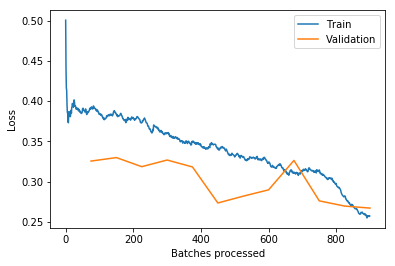

In [31]:
learn.recorder.plot_losses()

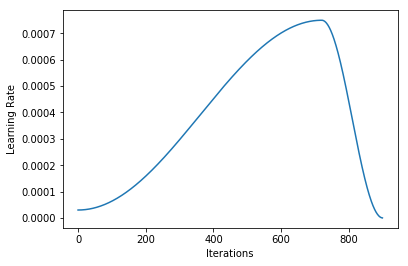

In [32]:
learn.recorder.plot_lr()

This plots your training loss and your validation loss. Quite often, they actually go up a bit before they go down. Why is that? That's because (you can also plot your learning rate over time and you'll see that) the learning rate goes up and then it goes down. Why is that? Because we said **fit_one_cycle**. That's what fit one cycle does. It actually makes the learning rate start low, go up, and then go down again.

Why is that a good idea? To find out why that's a good idea, let's first of all look at a really cool project done by José Fernández Portal during the week. He took our gradient descent demo notebook and actually plotted the weights over time, not just the ground truth and model over time. He did it for a few different learning rates.

Remember we had two weights we were doing basically y=ax+b or in his nomenclature $y=w_{0}x+w_{1}$.

We can actually look and see what happens to those weights over time. And we know this is the correct answer (marked with red X). A learning rate of 0.1, they're kind of like slides on in here and you can see that it takes a little bit of time to get to the right point. You can see the loss improving.

![alt text](https://github.com/hiromis/notes/raw/master/lesson3/jose1.gif?raw=true)

At a higher learning rate of 0.7, you can see that the model jumps to the ground truth really quickly. And you can see that the weights jump straight to the right place really quickly.

![](https://github.com/hiromis/notes/raw/master/lesson3/jose2.gif)

What if we have a learning rate that's really too high? You can see it takes a very very long time to get to the right point.

![](https://github.com/hiromis/notes/raw/master/lesson3/jose4.gif)

Or if it's really too high, it diverges.

![](https://github.com/hiromis/notes/raw/master/lesson3/jose5.gif)

So you can see why getting the right learning rate is important. When you get the right learning rate, it zooms into the best spot very quickly.

Now as you get closer to the final spot, something interesting happens which is that you really want your learning rate to decrease because you're getting close to the right spot.

So what actually happens is (I can only draw 2d sorry), you don't generally have some kind of loss function surface that looks like that (remember there's lots of dimensions), but it actually tends to look bumpy like that. So you want a learning rate that's like high enough to jump over the bumps, but once you get close to the best answer, you don't want to be just jumping backwards and forwards between bumps. You want your learning rate to go down so that as you get closer, you take smaller and smaller steps. That's why we want our learning rate to go down at the end.

![](https://github.com/hiromis/notes/blob/master/lesson3/whiteboard.gif)

This idea of decreasing the learning rate during training has been around forever. It's just called learning rate annealing. But the idea of gradually increasing it at the start is much more recent and it mainly comes from a guy called Leslie Smith ( [meetup with Leslie Smith](https://youtu.be/dxpyg3mP_rU)).

Loss function surfaces tend to have flat areas and bumpy areas. If you end up in the bottom of a bumpy area, that solution will tend not to generalize very well because you've found a solution that's good in that one place but it's not very good in other places. Where else if you found one in the flat area, it probably will generalize well because it's not only good in that one spot but it's good to kind of around it as well.

![](https://github.com/hiromis/notes/blob/master/lesson3/whiteboard2.gif)

If you have a really small learning rate, it'll tend to kind of plod down and stick in these places. But if you gradually increase the learning rate, then it'll kind of like jump down and as the learning rate goes up, it's going to start going up again like this. Then the learning rate is now going to be up here, it's going to be bumping backwards and forwards. Eventually the learning rate starts to come down again, and it'll tend to find its way to these flat areas.

So it turns out that gradually increasing the learning rate is a really good way of helping the model to explore the whole function surface, and try and find areas where both the loss is low and also it's not bumpy. Because if it was bumpy, it would get kicked out again. This allows us to train at really high learning rates, so it tends to mean that we solve our problem much more quickly, and we tend to end up with much more generalizable solutions.

**What you are looking for in plot_losses** [1:25:01](https://youtu.be/PW2HKkzdkKY?t=5101)

If you call **plot_losses** and find that it's just getting a little bit worse and then it gets a lot better you've found a really good maximum learning rate.

![](https://github.com/hiromis/notes/blob/master/lesson3/c6.png?raw=true)

So when you actually call fit one cycle, you're not actually passing in a learning rate. You're actually passing in a maximum learning rate. If it's kind of always going down, particularly after you unfreeze, that suggests you could probably bump your learning rates up a little bit﹣because you really want to see this kind of shape. It's going to train faster and generalize better. You'll tend to particularly see it in the validation set (the orange is the validation set). 

Again, the difference between kind of knowing this theory and being able to do it, is looking at lots of these pictures. So after you train stuff, type learn.recorder. and hit tab, and see what's in there﹣particularly the things that start with "plot" and start getting a sense of what are these pictures looking like when you're getting good results. Then try making the learning rate much higher, try making it much lower, more epochs, less epochs, and get a sense for what these look like.

**Go big** [1:26:16](https://youtu.be/PW2HKkzdkKY?t=5176)

In this case, we used the size (in our transforms) of the **original image size/2**. These two slashes in Python means integer divide because obviously we can't have half pixel amounts in our sizes. We use the batch size of 8. Now I found that fits on my GPU, it might not fit on yours. If it doesn't, you can just decrease the batch size down to 4.

This isn't really solving the problem because the problem is to segment all of the pixels﹣not half of the pixels. So I'm going to use the same trick that I did last time which is I'm now going to put the size up to the full size of the source images which means I now have to halve my batch size otherwise I'll run out of GPU memory.

In [33]:
#Learn.destroy() #uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU Ram

if free > 8200: bs=3
else:           bs=1
print(f'using bs={bs}, have {free}MB of GPU RAM free')

using bs=3, have 13175MB of GPU RAM free


In [0]:
data = (scr.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


In [0]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)


In [0]:
learn.load('stage-2');

I can either say learn.data = data but I actually found it had a lot of trouble with GPU memory, so I generally restarted my kernel, came back here, created a new learner, and loaded up the weights that I saved last time.

**The key thing is that this learner now has the same weights that I had before, but the data is now the full image size.**

In [37]:
learn.lr_find()
learn.recorder.plot()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

In [0]:
lr = 1e-3

In [0]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.8)

In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10,lrs)

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

In [0]:
learn.show_results(rows=3,figsize=(10,10))

You can go learn.show_results() to see how your predictions compare to the ground truth, and they really look pretty good.

How good is pretty good? An accuracy of 92.15%, the best paper I know of for segmentation was a paper called The One Hundred Layers Tiramisu which developed a convolutional dense net came out about two years ago. After I trained this today, I went back and looked at the paper to find their state-of-the-art accuracy and their best was 91.5% and we got 92.1%. I don't know if better results have come out since this paper, but I remember when this paper came out and it was a really big deal. I said "Wow, this is an exceptionally good segmentation result." When you compare it to the previous bests that they compared it to, it was a big step up.

In last year's course, we spent a lot of time re-implementing the hundred layers tiramisu. Now with our totally default fastai class, and it's easily beating 91.5%. I also remember I had to train for hours and hours. Where else, today's version, I trained in minutes. So this is a super strong architecture for segmentation.

I'm not going to promise that this is the definite state-of-the-art today, because I haven't done a complete literature search to see what's happened in the last two years. But it's certainly beating the world's best approach the last time I looked into this which was in last year's course basically. So these are all the little tricks we've picked up along the way in terms of how to train things well: things like using the pre-trained model and the one cycle convergence. All these little tricks they work extraordinarily well.

We actually haven't published the paper on the exact details of how this variation of the U-Net works﹣there's a few little tweaks we do, but if you come back for part 2, we'll be going into all of the details about how we make this work so well. But for you, all you have to know at this stage is that you can say learner.unet_learner and you should get great results also.



#Another trick: Mixed precision training -> boosting training speed [1:30:59](https://youtu.be/PW2HKkzdkKY?t=5459)

There's another trick you can use if you're running out of memory a lot. You can actually do something called mixed precision training. Mixed precision training means that (for those of you that have done a little bit of computer science) instead of using single precision floating point numbers, you can do most of the calculations in your model with half precision floating point numbers﹣so 16 bits instead of 32 bits. The very idea of this has only been around for the last couple of years﹣in terms of like hardware that actually does this reasonably quickly. Then fastai library, I think, is the first and probably still the only one that makes it actually easy to use this.

![alt text](https://github.com/hiromis/notes/blob/master/lesson3/34.png?raw=true)

If you add to_fp16() on the end of any learner call, you're actually going to get a model that trains in 16-bit precision. Because it's so new, you'll need to have the most recent CUDA drivers and all that stuff for this even to work. When I tried it this morning on some of the platforms, it just killed the kernel, so you need to make sure you've got the most recent drivers. If you've got a really recent GPU like 2080Ti, not only will it work, but it'll work about twice as fast as otherwise. The reason I'm mentioning it is that it's going to use less GPU RAM, so even if you don't have a 2080Ti, you'll probably find that things that didn't fit into your GPU without this, do fit in.

I actually have never seen people use mixed precision floating point for segmentation before, just for a bit of a laugh I tried it and actually discovered that I got even better result. I only found this this morning so I don't have anything more to add here rather than quite often when you make things a little bit less precise in deep learning, it generalizes a little bit better. I've never seen a 92.5% accuracy on CamVid before, so not only will this be faster, you'll be able to use bigger batch sizes, but you might even find like I did that you get an even better result. So that's a cool little trick.

You just need to make sure that every time you create a learner you add this to_fp16(). If your kernel dies, it probably means you have slightly out of date CUDA drivers or maybe even a too old graphics card. I'm not sure exactly which cards support FP16.